# 1. DATA ACQUISITION AND PREPROCESSING

Load datasets & Data quality

In [2]:
# Import project and credit databases separately for initial exploration
import pandas as pd

credits = pd.read_csv('/content/credits.csv')
projects = pd.read_csv('/content/projects.csv')

print(credits.info())
print(projects.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97415 entries, 0 to 97414
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   project_id                         97415 non-null  object 
 1   quantity                           97415 non-null  int64  
 2   retirement_account                 0 non-null      float64
 3   retirement_beneficiary             75368 non-null  object 
 4   retirement_beneficiary_harmonized  25964 non-null  object 
 5   retirement_note                    74740 non-null  object 
 6   retirement_reason                  75551 non-null  object 
 7   transaction_date                   97414 non-null  object 
 8   transaction_type                   97414 non-null  object 
 9   vintage                            97414 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 7.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10546 

In [3]:
print("Project data dimensions:", projects.shape)
print("Credit data dimensions:", credits.shape)

Project data dimensions: (10546, 17)
Credit data dimensions: (97415, 10)


In [4]:
credits.head()

,project_id,quantity,retirement_account,retirement_beneficiary,retirement_beneficiary_harmonized,retirement_note,retirement_reason,transaction_date,transaction_type,vintage
0,VCS1,12630,NaN,NaN,NaN,NaN,NaN,2009-03-26 00:00:00+00:00,issuance,2007.0
1,VCS1,9074,NaN,NaN,NaN,NaN,NaN,2014-01-21 00:00:00+00:00,issuance,2006.0
2,VCS10,153460,NaN,NaN,NaN,NaN,NaN,2009-04-22 00:00:00+00:00,issuance,2006.0
3,VCS10,368968,NaN,NaN,NaN,NaN,NaN,2009-04-22 00:00:00+00:00,issuance,2007.0
4,VCS10,505908,NaN,NaN,NaN,NaN,NaN,2009-04-22 00:00:00+00:00,issuance,2008.0


In [5]:
projects.head()

,category,country,first_issuance_at,first_retirement_at,is_compliance,issued,listed_at,name,project_id,project_type,project_type_source,project_url,proponent,protocol,registry,retired,status
0,unknown,Brazil,NaN,NaN,False,0,NaN,TOURBA PROJECT – IMPROVED AGRICULTURAL PRACTIC...,VCS5618,Unknown,carbonplan,https://registry.verra.org/app/projectDetail/V...,TOURBA BRAZIL LTDA,['vm0042'],verra,0,listed
1,unknown,India,NaN,NaN,False,0,NaN,Biospark CBG Project,VCS5612,Unknown,carbonplan,https://registry.verra.org/app/projectDetail/V...,Biospark Energy Private Limited,['AMS-I.C.; AMS-III.D.; AMS-III.AO.'],verra,0,listed
2,unknown,Egypt,NaN,NaN,False,0,NaN,Abu Minqar Solar PV Projects,VCS5606,Unknown,carbonplan,https://registry.verra.org/app/projectDetail/V...,Multiple Proponents,['ams-i-f'],verra,0,listed
3,unknown,Brazil,NaN,NaN,False,0,NaN,Manduri Caatinga Grouped IFM Project,VCS5608,Unknown,carbonplan,https://registry.verra.org/app/projectDetail/V...,Future Climate Ltd,['vm0003'],verra,0,listed
4,unknown,France,NaN,NaN,False,0,NaN,Humus Program,VCS5607,Unknown,carbonplan,https://registry.verra.org/app/projectDetail/V...,Milpa Groupe,['vm0042'],verra,0,listed


# 2. PROJECT-LEVEL ANALYSIS (Baseline Characteristics)

## 2.1 PROJECT DATABASE PREPROCESSING

In [6]:
# Create a working copy to preserve original data integrity
# This ensures reproducibility and allows for alternative preprocessing approaches
df_projects_processed = projects.copy()

In [7]:
# check the missing value in Projects
missing_ratio = df_projects_processed.isnull().sum() / len(projects)
print("Missing Ratio:")
print(missing_ratio[missing_ratio > 0])

Missing Ratio:
first_issuance_at      0.480087
first_retirement_at    0.571401
listed_at              0.893514
name                   0.000095
proponent              0.085435
dtype: float64


In [8]:
# 1. Drop variables with excessive missing values (>60% threshold)
# Note: Adjusted threshold to 60% to retain more variables
columns_to_drop = missing_ratio[missing_ratio > 0.6].index.tolist()
df_projects_processed = df_projects_processed.drop(columns=columns_to_drop)
print(f"Removed {len(columns_to_drop)} columns due to excessive missing values")

# 2. Handle moderate missingness (5-60%)

# For categorical variables
df_projects_processed['proponent'] = df_projects_processed['proponent'].fillna('Unknown')

# Convert to datetime first, then handle appropriately
df_projects_processed['first_issuance_at'] = pd.to_datetime(
    df_projects_processed['first_issuance_at'], errors='coerce'
)
df_projects_processed['first_retirement_at'] = pd.to_datetime(
    df_projects_processed['first_retirement_at'], errors='coerce'
)

# Keep as NaT (Not a Time) for temporal analysis
df_projects_processed['issuance_date_missing'] = df_projects_processed['first_issuance_at'].isna()
df_projects_processed['retirement_date_missing'] = df_projects_processed['first_retirement_at'].isna()

# 3. Handle minimal missingness (<5%)
minimal_missing = missing_ratio[(missing_ratio > 0) & (missing_ratio < 0.05)].index
df_projects_processed = df_projects_processed.dropna(subset=minimal_missing)

# Verify data completeness
print("\nPost-processing missing value summary:")
print(df_projects_processed.isnull().sum())
print(f"Final dataset dimensions: {df_projects_processed.shape}")

Removed 1 columns due to excessive missing values

Post-processing missing value summary:
category                      0
country                       0
first_issuance_at          5062
first_retirement_at        6025
is_compliance                 0
issued                        0
name                          0
project_id                    0
project_type                  0
project_type_source           0
project_url                   0
proponent                     0
protocol                      0
registry                      0
retired                       0
status                        0
issuance_date_missing         0
retirement_date_missing       0
dtype: int64
Final dataset dimensions: (10545, 18)


## 2.2 PROJECT CHARACTERISTICS AND RETIREMENT VOLUME ANALYSIS

*   Research Question: What project characteristics are associated with greater retirement volumes?  
*   Approach: Examine retirement patterns across project attributes

### Category, Country, Registry, Protocol

2.2.1 Retirement Volume by Project Category
*   Analyze distribution of retired credits across different project types



In [9]:
# Aggregate retirement volumes by category
retirement_by_category = df_projects_processed.groupby('category').agg({
    'retired': ['sum', 'mean', 'count', 'std']
}).round(2)

# Flatten column names for clarity
retirement_by_category.columns = ['total_retired', 'mean_retired', 'project_count', 'std_retired']
retirement_by_category = retirement_by_category.sort_values('total_retired', ascending=False)

print("Retirement Volume by Project Category:")
print(retirement_by_category.head(10))


Retirement Volume by Project Category:
                   total_retired  mean_retired  project_count  std_retired
category                                                                  
forest                 539732373     288318.58           1872   1632835.33
renewable-energy       407786534     193080.75           2112    660089.06
ghg-management         244167849     114794.48           2127    417247.23
fuel-switching         130280482      64719.56           2013    362783.48
energy-efficiency       40257541      34203.52           1177    327804.96
land-use                 8599953      50292.12            171    287270.26
agriculture              3389162       6287.87            539     33272.72
carbon-capture             57616       2216.00             26      8237.95
biochar                        0          0.00              9         0.00
unknown                        0          0.00            499         0.00


2.2.2 Geographical Analysis of Retirement Patterns
*  Examine retirement volumes across countries



In [10]:
retirement_by_country = df_projects_processed.groupby('country').agg({
    'retired': ['sum', 'mean', 'count']
}).round(2)

retirement_by_country.columns = ['total_retired', 'mean_retired', 'project_count']
retirement_by_country = retirement_by_country.sort_values('total_retired', ascending=False)

# Filter for countries with significant project presence (>10 projects)
significant_countries = retirement_by_country[retirement_by_country['project_count'] > 10]

print("Retirement Volume by Country:")
print(retirement_by_country.head(10))

Retirement Volume by Country:
               total_retired  mean_retired  project_count
country                                                  
United States      337648746     193384.16           1746
India              227524475     126402.49           1800
China              145568645      94648.01           1538
Indonesia           77490900    1061519.18             73
Brazil              76671520     215369.44            356
Türkiye             72266942     130681.63            553
Peru                54389338     799843.21             68
Kenya               39358500     121103.08            325
Colombia            29882801     259850.44            115
Cambodia            23964181     630636.34             38


2.2.3 Registry-based Retirement Analysis
*   Compare retirement performance across different registries



In [11]:
retirement_by_registry = df_projects_processed.groupby('registry').agg({
    'retired': ['sum', 'mean', 'count'],
    'issued': 'sum'  # Include issuance for retirement rate calculation
}).round(2)

retirement_by_registry.columns = ['total_retired', 'mean_retired', 'project_count', 'total_issued']
retirement_by_registry['retirement_rate'] = (
    retirement_by_registry['total_retired'] / retirement_by_registry['total_issued'] * 100
).round(2)

print("Retirement Volume by Registry:")
print(retirement_by_registry.head(10))

Retirement Volume by Registry:
                          total_retired  mean_retired  project_count  \
registry                                                               
american-carbon-registry      160663011     178713.03            899   
art-trees                        201408       7746.46             26   
climate-action-reserve        154794529     137229.19           1128   
gold-standard                 214160781      56033.69           3822   
verra                         844451781     180824.79           4670   

                          total_issued  retirement_rate  
registry                                                 
american-carbon-registry     337530024            47.60  
art-trees                     49447890             0.41  
climate-action-reserve       223448283            69.28  
gold-standard                427882883            50.05  
verra                       1423435818            59.32  


2.2.4 Protocol-specific Retirement Patterns
*   Analyze how different protocols influence retirement volumes



In [12]:
retirement_by_protocol = df_projects_processed.groupby('protocol').agg({
    'retired': ['sum', 'mean', 'count', 'median']
}).round(2)

retirement_by_protocol.columns = ['total_retired', 'mean_retired', 'project_count', 'median_retired']
retirement_by_protocol = retirement_by_protocol.sort_values('total_retired', ascending=False)

print("Retirement Volume by Protocol:")
print(retirement_by_protocol.head(10))

Retirement Volume by Protocol:
                  total_retired  mean_retired  project_count  median_retired
protocol                                                                    
['acm0002']           363826063     278793.92           1305         51825.0
['arb-forest']        146617378     557480.52            263             0.0
['vm0007']            126351754    1118157.12            113             0.0
['vm0009']             74870064    2581726.34             29             0.0
['vm0015']             65856554     577689.07            114             0.0
['gs-tpddtec']         53614650      56976.25            941             0.0
['car-landfill']       35787745     281793.27            127        163259.0
['acm0001']            32978828     177305.53            186             0.0
['ams-i-d']            26910562      41786.59            644           542.0
['vm0004']             26409625   26409625.00              1      26409625.0


2.2.5 Multi-dimensional Analysis
*   Examine interaction effects between characteristics

In [13]:
# Category-Country interaction
category_country_retirement = df_projects_processed.groupby(['category', 'country'])['retired'].agg([
    'sum', 'mean', 'count'
]).round(2)

# Filter for meaningful combinations (>5 projects)
category_country_retirement = category_country_retirement[category_country_retirement['count'] > 5]
category_country_retirement = category_country_retirement.sort_values('sum', ascending=False).head(20)

print("Retirement Volume by Retiremnet and Country:")
print(category_country_retirement.head(10))

Retirement Volume by Retiremnet and Country:
                                      sum        mean  count
category         country                                    
renewable-energy India          195741079   255870.69    765
forest           United States  173576704   339680.44    511
ghg-management   United States  150265607   151172.64    994
renewable-energy China           83962869   224499.65    374
forest           Indonesia       63756021  3542001.17     18
renewable-energy Türkiye         58086378   146313.29    397
forest           Peru            52138146  1184957.86     44
                 Brazil          50028264   296025.23    169
                 Colombia        28846804   418069.62     69
ghg-management   China           23107002    50562.37    457


2.2.6 Statistical Visualization
*   Create comprehensive visualizations for key findings




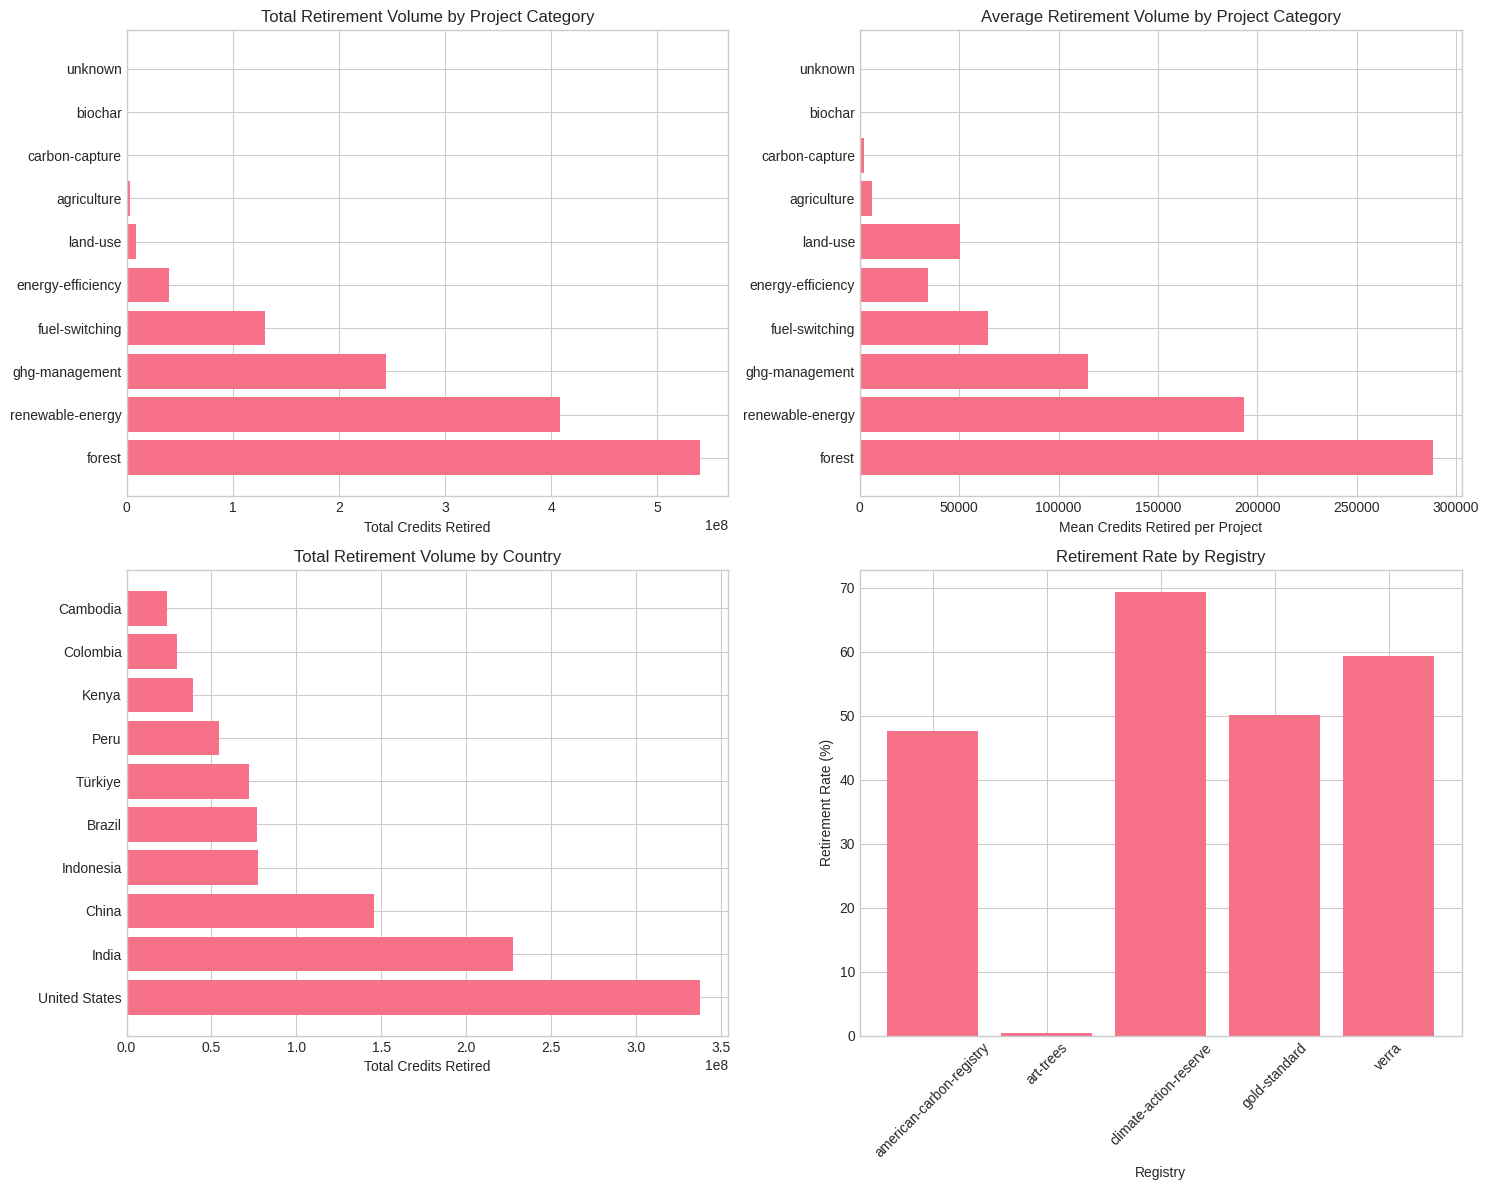

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set academic plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Figure 1: Top categories by retirement volume
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Subplot 1: Total retirement by category
top_categories = retirement_by_category.head(10)
axes[0,0].barh(top_categories.index, top_categories['total_retired'])
axes[0,0].set_xlabel('Total Credits Retired')
axes[0,0].set_title('Total Retirement Volume by Project Category')

# Subplot 2: Mean retirement by category
axes[0,1].barh(top_categories.index, top_categories['mean_retired'])
axes[0,1].set_xlabel('Mean Credits Retired per Project')
axes[0,1].set_title('Average Retirement Volume by Project Category')

# Subplot 3: Top countries by retirement
top_countries = significant_countries.head(10)
axes[1,0].barh(top_countries.index, top_countries['total_retired'])
axes[1,0].set_xlabel('Total Credits Retired')
axes[1,0].set_title('Total Retirement Volume by Country')

# Subplot 4: Registry performance
axes[1,1].bar(retirement_by_registry.index, retirement_by_registry['retirement_rate'])
axes[1,1].set_xlabel('Registry')
axes[1,1].set_ylabel('Retirement Rate (%)')
axes[1,1].set_title('Retirement Rate by Registry')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

2.2.7 Statistical Testing
*   Perform statistical tests to validate observed differences




In [15]:
from scipy import stats

# ANOVA test for retirement volumes across categories
categories = [group['retired'].values for name, group in df_projects_processed.groupby('category')]
f_stat, p_value = stats.f_oneway(*categories)
print(f"\nANOVA Results for Category Effect on Retirement:")
print(f"F-statistic: {f_stat:.4f}, p-value: {p_value:.4e}")

# Kruskal-Wallis test (non-parametric alternative)
h_stat, p_value_kw = stats.kruskal(*categories)
print(f"\nKruskal-Wallis Results for Category Effect on Retirement:")
print(f"H-statistic: {h_stat:.4f}, p-value: {p_value_kw:.4e}")


ANOVA Results for Category Effect on Retirement:
F-statistic: 16.3814, p-value: 4.7694e-27

Kruskal-Wallis Results for Category Effect on Retirement:
H-statistic: 1232.3486, p-value: 1.2580e-259


In [16]:
categories = [group['retired'].values for name, group in df_projects_processed.groupby('country')]
f_stat, p_value = stats.f_oneway(*categories)
print(f"\nANOVA Results for Country Effect on Retirement:")
print(f"F-statistic: {f_stat:.4f}, p-value: {p_value:.4e}")

# Kruskal-Wallis test (non-parametric alternative)
h_stat, p_value_kw = stats.kruskal(*categories)
print(f"\nKruskal-Wallis Results for Country Effect on Retirement:")
print(f"H-statistic: {h_stat:.4f}, p-value: {p_value_kw:.4e}")


ANOVA Results for Country Effect on Retirement:
F-statistic: 1.9744, p-value: 4.1785e-11

Kruskal-Wallis Results for Country Effect on Retirement:
H-statistic: 915.0469, p-value: 5.4409e-112


In [17]:
categories = [group['retired'].values for name, group in df_projects_processed.groupby('protocol')]
f_stat, p_value = stats.f_oneway(*categories)
print(f"\nANOVA Results for protocol Effect on Retirement:")
print(f"F-statistic: {f_stat:.4f}, p-value: {p_value:.4e}")

# Kruskal-Wallis test (non-parametric alternative)
h_stat, p_value_kw = stats.kruskal(*categories)
print(f"\nKruskal-Wallis Results for protocol Effect on Retirement:")
print(f"H-statistic: {h_stat:.4f}, p-value: {p_value_kw:.4e}")


ANOVA Results for protocol Effect on Retirement:
F-statistic: 6.4811, p-value: 1.3483e-246

Kruskal-Wallis Results for protocol Effect on Retirement:
H-statistic: 2622.3388, p-value: 0.0000e+00


In [18]:
categories = [group['retired'].values for name, group in df_projects_processed.groupby('registry')]
f_stat, p_value = stats.f_oneway(*categories)
print(f"\nANOVA Results for registry Effect on Retirement:")
print(f"F-statistic: {f_stat:.4f}, p-value: {p_value:.4e}")

# Kruskal-Wallis test (non-parametric alternative)
h_stat, p_value_kw = stats.kruskal(*categories)
print(f"\nKruskal-Wallis Results for registry Effect on Retirement:")
print(f"H-statistic: {h_stat:.4f}, p-value: {p_value_kw:.4e}")


ANOVA Results for registry Effect on Retirement:
F-statistic: 13.8953, p-value: 2.6272e-11

Kruskal-Wallis Results for registry Effect on Retirement:
H-statistic: 274.5372, p-value: 3.3553e-58


### ADDITIONAL PROJECT CHARACTERISTICS

2.2.1 Compliance Effect

In [19]:
compliance_analysis = df_projects_processed.groupby('is_compliance').agg({
    'retired': ['sum', 'mean', 'count', 'std'],
    'issued': 'sum'
}).round(2)

compliance_analysis.columns = ['total_retired', 'mean_retired', 'project_count',
                               'std_retired', 'total_issued']
compliance_analysis['retirement_rate'] = (
    compliance_analysis['total_retired'] / compliance_analysis['total_issued'] * 100
).round(2)

print("Retirement Analysis by Compliance Status:")
print(compliance_analysis)

# Statistical test for compliance effect
compliance_groups = df_projects_processed.groupby('is_compliance')['retired'].apply(list)
t_stat, p_value = stats.ttest_ind(compliance_groups.iloc[0], compliance_groups.iloc[1])
print(f"\nT-test for Compliance Effect: t={t_stat:.4f}, p={p_value:.4f}")

Retirement Analysis by Compliance Status:
               total_retired  mean_retired  project_count  std_retired  \
is_compliance                                                            
False             1194505008     121331.13           9845    791048.47   
True               179766502     256809.29            700    930857.42   

               total_issued  retirement_rate  
is_compliance                                 
False            2202614031            54.23  
True              259130867            69.37  

T-test for Compliance Effect: t=-4.3235, p=0.0000


2.2.2 Project Status Impact on Retirement

In [20]:
status_analysis = df_projects_processed.groupby('status').agg({
    'retired': ['sum', 'mean', 'count', 'median'],
    'issued': 'sum'
}).round(2)

status_analysis.columns = ['total_retired', 'mean_retired', 'project_count',
                          'median_retired', 'total_issued']
status_analysis['retirement_efficiency'] = (
    status_analysis['total_retired'] / status_analysis['total_issued'] * 100
).round(2)
status_analysis = status_analysis.sort_values('total_retired', ascending=False)

print("\nRetirement Analysis by Project Status:")
print(status_analysis)


Retirement Analysis by Project Status:
            total_retired  mean_retired  project_count  median_retired  \
status                                                                   
registered      706579786     342003.77           2066         23236.5   
unknown         431082879     106466.51           4049          6579.0   
completed       135826161      86789.88           1565             0.0   
active          100770734     740961.28            136        109103.5   
canceled            11950       2987.50              4           327.5   
listed                  0          0.00           2723             0.0   
inactive                0          0.00              2             0.0   

            total_issued  retirement_efficiency  
status                                           
registered    1291100648                  54.73  
unknown        763999571                  56.42  
completed      254403064                  53.39  
active         142864791                  7

2.2.3 Project Type Granular Analysis

In [21]:
project_type_analysis = df_projects_processed.groupby('project_type').agg({
    'retired': ['sum', 'mean', 'count'],
    'issued': 'sum',
    'category': 'first'  # To link back to broader category
}).round(2)

project_type_analysis.columns = ['total_retired', 'mean_retired', 'project_count',
                                'total_issued', 'parent_category']
project_type_analysis['retirement_rate'] = (
    project_type_analysis['total_retired'] / project_type_analysis['total_issued'] * 100
).round(2)

# Filter for significant project types (>20 projects)
significant_types = project_type_analysis[project_type_analysis['project_count'] > 20]
significant_types = significant_types.sort_values('total_retired', ascending=False)

print("\nTop 15 Project Types by Retirement Volume:")
print(significant_types.head(15))


Top 15 Project Types by Retirement Volume:
                               total_retired  mean_retired  project_count  \
project_type                                                                
REDD+                              308751695     900150.71            343   
Wind                               204089229     199891.51           1021   
Improved Forest Management         178054957     195235.70            912   
Hydropower                         124713575     234424.01            532   
Cookstove                           87284541      54382.89           1605   
Landfill                            75684841     181934.71            416   
Centralized Solar                   63919174     183149.50            349   
Afforestation + Reforestation       44986948      75103.42            599   
Ozone Depleting Substances          27938840      91602.75            305   
Mine Methane                        26492590     141671.60            187   
Biomass                         

2.2.4 Proponent Analysis

In [22]:
# First, clean proponent names (handle 'Unknown' from missing value treatment)
df_projects_clean_proponent = df_projects_processed[
    df_projects_processed['proponent'] != 'Unknown'
].copy()

proponent_analysis = df_projects_clean_proponent.groupby('proponent').agg({
    'retired': ['sum', 'mean', 'count'],
    'issued': 'sum',
    'category': lambda x: x.mode()[0] if not x.empty else 'Mixed'  # Most common category
}).round(2)

proponent_analysis.columns = ['total_retired', 'mean_retired', 'project_count',
                             'total_issued', 'primary_category']
proponent_analysis['retirement_rate'] = (
    proponent_analysis['total_retired'] / proponent_analysis['total_issued'] * 100
).round(2)

# Filter for significant proponents (>5 projects)
significant_proponents = proponent_analysis[proponent_analysis['project_count'] > 5]
top_proponents = significant_proponents.sort_values('total_retired', ascending=False).head(20)

print("\nTop 20 Proponents by Retirement Volume:")
print(top_proponents[['total_retired', 'project_count', 'retirement_rate', 'primary_category']])


Top 20 Proponents by Retirement Volume:
                                                    total_retired  \
proponent                                                           
Multiple Proponents                                     161361586   
Impact Carbon                                            14695937   
South Pole Ltd                                            9773160   
Carbon-TF B.V.                                            9244914   
CO2balance UK ltd                                         8844704   
Apraava Renewable Energy Private Limited                  7026252   
3Degrees Group, Inc                                       7012969   
Adani Green Energy Limited                                6709634   
Reclamation Technologies Inc.                             6567567   
Orange Renewable Power Pvt Ltd                            6416317   
The Nature Conservancy                                    6391332   
NHPC Ltd                                                  6364

2.2.5 Multi-factor Analysis

In [23]:
# Examine interaction effects between compliance status and other factors

# Compliance × Category interaction
compliance_category = df_projects_processed.groupby(['is_compliance', 'category']).agg({
    'retired': ['sum', 'mean', 'count']
}).round(2)

compliance_category.columns = ['total_retired', 'mean_retired', 'project_count']
compliance_category = compliance_category[compliance_category['project_count'] > 10]
print("\nTop 15 compliance category:")
print(compliance_category.head(15))


Top 15 compliance category:
                                 total_retired  mean_retired  project_count
is_compliance category                                                     
False         agriculture              3389162       6287.87            539
              carbon-capture             57616       2216.00             26
              energy-efficiency       40257541      34203.52           1177
              forest                 393114995     244019.24           1611
              fuel-switching         130280482      64719.56           2013
              ghg-management         211018725     124421.42           1696
              land-use                 8599953      50292.12            171
              renewable-energy       407786534     193080.75           2112
              unknown                        0          0.00            491
True          forest                 146617378     561752.41            261
              ghg-management          33149124      76912.1

2.2.6 Visualizaiton

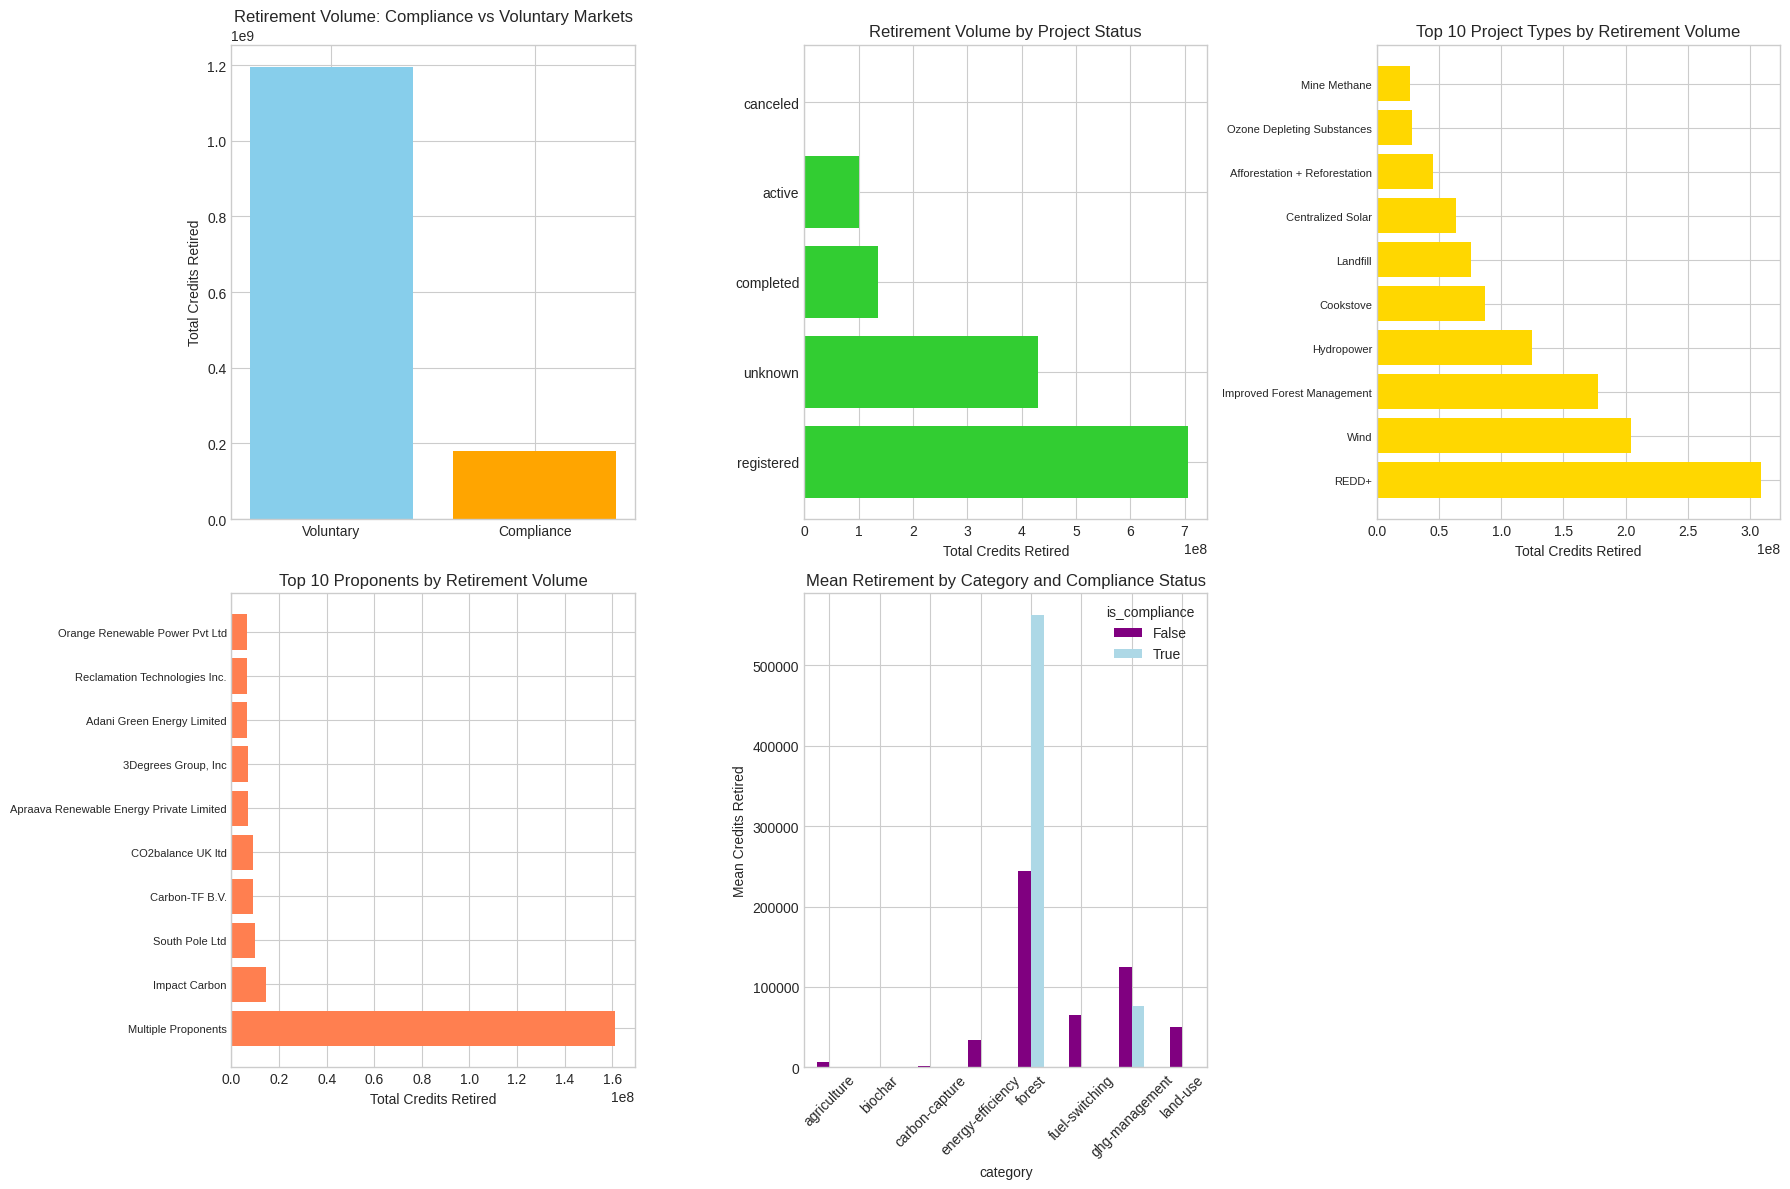

In [24]:
# Comprehensive Visualization

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Compliance vs Voluntary retirement volumes
compliance_data = compliance_analysis.reset_index()
axes[0, 0].bar(['Voluntary', 'Compliance'], compliance_data['total_retired'], color=['skyblue', 'orange'])
axes[0, 0].set_ylabel('Total Credits Retired')
axes[0, 0].set_title('Retirement Volume: Compliance vs Voluntary Markets')

# Plot 2: Project status distribution
status_data = status_analysis.head(5).reset_index()
axes[0, 1].barh(status_data['status'], status_data['total_retired'], color='limegreen')
axes[0, 1].set_xlabel('Total Credits Retired')
axes[0, 1].set_title('Retirement Volume by Project Status')

# Plot 3: Top project types
top_types = significant_types.head(10).reset_index()
axes[0, 2].barh(range(len(top_types)), top_types['total_retired'], color='gold')
axes[0, 2].set_yticks(range(len(top_types)))
axes[0, 2].set_yticklabels(top_types['project_type'], fontsize=8)
axes[0, 2].set_xlabel('Total Credits Retired')
axes[0, 2].set_title('Top 10 Project Types by Retirement Volume')

# Plot 4: Top proponents
top_prop_plot = top_proponents.head(10).reset_index()
axes[1, 0].barh(range(len(top_prop_plot)), top_prop_plot['total_retired'], color='coral')
axes[1, 0].set_yticks(range(len(top_prop_plot)))
axes[1, 0].set_yticklabels(top_prop_plot['proponent'][:30], fontsize=8)  # Truncate long names
axes[1, 0].set_xlabel('Total Credits Retired')
axes[1, 0].set_title('Top 10 Proponents by Retirement Volume')

# Plot 5: Compliance × Category interaction
compliance_cat_pivot = df_projects_processed.pivot_table(
    values='retired',
    index='category',
    columns='is_compliance',
    aggfunc='mean'
).head(8)
compliance_cat_pivot.plot(kind='bar', ax=axes[1, 1], color=['purple', 'lightblue'])
axes[1, 1].set_ylabel('Mean Credits Retired')
axes[1, 1].set_title('Mean Retirement by Category and Compliance Status')
axes[1, 1].tick_params(axis='x', rotation=45)

# Hide the sixth plot (bottom-right plot in 2x3 layout)
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

2.2.7 Summary Insights

In [25]:

print("\n=== KEY FINDINGS ===")
print(f"1. Compliance market represents {compliance_analysis.loc[True, 'total_retired'] / compliance_analysis['total_retired'].sum() * 100:.1f}% of total retirements")
print(f"2. Top project type '{significant_types.index[0]}' accounts for {significant_types.iloc[0]['total_retired']:,.0f} retired credits")
print(f"4. Top proponent '{top_proponents.index[0]}' has retired {top_proponents.iloc[0]['total_retired']:,.0f} credits across {top_proponents.iloc[0]['project_count']:.0f} projects")


=== KEY FINDINGS ===
1. Compliance market represents 13.1% of total retirements
2. Top project type 'REDD+' accounts for 308,751,695 retired credits
4. Top proponent 'Multiple Proponents' has retired 161,361,586 credits across 648 projects


### 2.3 Regression

 2.3.1 Data Preparation

In [26]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df_regression = df_projects_processed.copy()

# Log transformation
df_regression['log_retired'] = np.log1p(df_regression['retired'])
df_regression['log_issued'] = np.log1p(df_regression['issued'])

# Check for perfect separation issues
print("Checking for perfect separation in key variables:")
print("\nCompliance distribution by category:")
compliance_dist = pd.crosstab(df_regression['category'], df_regression['is_compliance'])
print(compliance_dist)

# Remove categories with perfect separation (only one compliance type)
categories_to_keep = []
for cat in compliance_dist.index:
    if compliance_dist.loc[cat, False] > 0 and compliance_dist.loc[cat, True] > 0:
        categories_to_keep.append(cat)

print(f"\nCategories with both compliance types: {categories_to_keep}")

# Strategy 1: Focus on categories with variation
df_balanced = df_regression[df_regression['category'].isin(categories_to_keep)].copy()

# Strategy 2: Create separate models for voluntary and compliance markets
df_voluntary = df_regression[df_regression['is_compliance'] == False].copy()
df_compliance = df_regression[df_regression['is_compliance'] == True].copy()

print(f"\nSample sizes:")
print(f"Full sample: {len(df_regression)}")
print(f"Balanced sample: {len(df_balanced)}")
print(f"Voluntary only: {len(df_voluntary)}")

print(f"Compliance only: {len(df_compliance)}")

Checking for perfect separation in key variables:

Compliance distribution by category:
is_compliance      False  True 
category                       
agriculture          539      0
biochar                9      0
carbon-capture        26      0
energy-efficiency   1177      0
forest              1611    261
fuel-switching      2013      0
ghg-management      1696    431
land-use             171      0
renewable-energy    2112      0
unknown              491      8

Categories with both compliance types: ['forest', 'ghg-management', 'unknown']

Sample sizes:
Full sample: 10545
Balanced sample: 4498
Voluntary only: 9845
Compliance only: 700


2.3.2 Model 1: Voluntary Market Analysis

In [27]:
print("\n" + "=" * 80)
print("MODEL 1: VOLUNTARY MARKET ANALYSIS")
print("=" * 80)

# Simplify countries for voluntary market
top_countries_vol = df_voluntary['country'].value_counts().head(10).index
df_voluntary['country_grouped'] = df_voluntary['country'].apply(
    lambda x: x if x in top_countries_vol else 'Other'
)

# Voluntary market model
formula_voluntary = 'log_retired ~ C(category) + C(country_grouped) + C(registry) + log_issued'

try:
    model_voluntary = smf.ols(formula_voluntary, data=df_voluntary).fit(cov_type='HC3')

    # Display key results
    print(f"\nModel Statistics:")
    print(f"N = {int(model_voluntary.nobs)}")
    print(f"R-squared = {model_voluntary.rsquared:.4f}")
    print(f"Adj. R-squared = {model_voluntary.rsquared_adj:.4f}")

    # Show significant predictors only
    significant_vars = model_voluntary.pvalues[model_voluntary.pvalues < 0.05]
    print(f"\nSignificant predictors (p < 0.05):")
    for var in significant_vars.index:
        if var != 'Intercept':
            coef = model_voluntary.params[var]
            pval = model_voluntary.pvalues[var]
            print(f"{var}: coef={coef:.4f}, p={pval:.4f}")

except Exception as e:
    print(f"Model estimation failed: {e}")


MODEL 1: VOLUNTARY MARKET ANALYSIS

Model Statistics:
N = 9845
R-squared = 0.7391
Adj. R-squared = 0.7385

Significant predictors (p < 0.05):
C(category)[T.energy-efficiency]: coef=0.3068, p=0.0153
C(category)[T.renewable-energy]: coef=0.7773, p=0.0000
C(country_grouped)[T.China]: coef=-1.1106, p=0.0000
C(country_grouped)[T.India]: coef=-0.9962, p=0.0000
C(country_grouped)[T.Kenya]: coef=-0.7782, p=0.0021
C(country_grouped)[T.Mexico]: coef=-2.2881, p=0.0000
C(country_grouped)[T.Other]: coef=-1.0356, p=0.0000
C(country_grouped)[T.Türkiye]: coef=-1.4779, p=0.0000
C(registry)[T.art-trees]: coef=1.6846, p=0.0000
C(registry)[T.climate-action-reserve]: coef=2.3299, p=0.0000
C(registry)[T.gold-standard]: coef=1.2546, p=0.0000
C(registry)[T.verra]: coef=1.8495, p=0.0000
log_issued: coef=0.7893, p=0.0000


2.3.3 Model 2: Compliance Market Analysis

In [28]:
print("\n" + "=" * 80)
print("MODEL 2: COMPLIANCE MARKET ANALYSIS")
print("=" * 80)

if len(df_compliance) > 50:  # Only if sufficient observations
    # Note: Compliance market has fewer categories
    compliance_categories = df_compliance['category'].value_counts()
    print(f"\nCompliance market categories:")
    print(compliance_categories)

    # Simpler model for compliance due to fewer observations
    formula_compliance = 'log_retired ~ C(category) + log_issued'

    try:
        model_compliance = smf.ols(formula_compliance, data=df_compliance).fit()

        print(f"\nModel Statistics:")
        print(f"N = {int(model_compliance.nobs)}")
        print(f"R-squared = {model_compliance.rsquared:.4f}")
        print(f"Adj. R-squared = {model_compliance.rsquared_adj:.4f}")

        # Show results
        print(f"\nKey coefficients:")
        for var in model_compliance.params.index:
            if var != 'Intercept':
                coef = model_compliance.params[var]
                pval = model_compliance.pvalues[var]
                if pval < 0.1:  # More lenient due to smaller sample
                    print(f"{var}: coef={coef:.4f}, p={pval:.4f}")

    except Exception as e:
        print(f"Model estimation failed: {e}")
else:
    print("Insufficient observations for compliance market analysis")


MODEL 2: COMPLIANCE MARKET ANALYSIS

Compliance market categories:
category
ghg-management    431
forest            261
unknown             8
Name: count, dtype: int64

Model Statistics:
N = 700
R-squared = 0.6763
Adj. R-squared = 0.6749

Key coefficients:
log_issued: coef=0.8801, p=0.0000


2.3.4 Model 3: Pooled Model with Market Indicator

In [29]:
print("\n" + "=" * 80)
print("MODEL 3: POOLED MODEL WITH MARKET TYPE INDICATOR")
print("=" * 80)

# Use full sample but with simplified categories
# Group categories by market prevalence
df_regression['market_category'] = 'Other'
df_regression.loc[df_regression['category'].isin(['forest', 'ghg-management']),
                  'market_category'] = 'Mixed_Market'
df_regression.loc[df_regression['category'].isin(['renewable-energy', 'energy-efficiency']),
                  'market_category'] = 'Voluntary_Only'

# Simplified pooled model
formula_pooled = '''log_retired ~ C(market_category) + C(is_compliance) +
                   C(registry) + log_issued'''

try:
    model_pooled = smf.ols(formula_pooled, data=df_regression).fit(cov_type='HC3')

    print(f"\nModel Statistics:")
    print(f"N = {int(model_pooled.nobs)}")
    print(f"R-squared = {model_pooled.rsquared:.4f}")
    print(f"Adj. R-squared = {model_pooled.rsquared_adj:.4f}")

    # Key findings
    print(f"\nKey findings:")
    if 'C(is_compliance)[T.True]' in model_pooled.params:
        compliance_effect = model_pooled.params['C(is_compliance)[T.True]']
        compliance_pval = model_pooled.pvalues['C(is_compliance)[T.True]']
        print(f"Compliance effect: {compliance_effect:.4f} (p={compliance_pval:.4f})")
        if compliance_pval < 0.05:
            effect_pct = (np.exp(compliance_effect) - 1) * 100
            print(f"→ Compliance projects have {effect_pct:.1f}% different retirement levels")

    issued_effect = model_pooled.params['log_issued']
    print(f"Issuance elasticity: {issued_effect:.4f} (p={model_pooled.pvalues['log_issued']:.4f})")

except Exception as e:
    print(f"Model estimation failed: {e}")


MODEL 3: POOLED MODEL WITH MARKET TYPE INDICATOR

Model Statistics:
N = 10545
R-squared = 0.7341
Adj. R-squared = 0.7339

Key findings:
Compliance effect: 1.0915 (p=0.0000)
→ Compliance projects have 197.9% different retirement levels
Issuance elasticity: 0.8009 (p=0.0000)


2.3.5 Alternative: Non-parametric Analysis

In [30]:
print("\n" + "=" * 80)
print("NON-PARAMETRIC ANALYSIS")
print("=" * 80)

# Mann-Whitney U test for compliance effect
from scipy import stats

voluntary_retired = df_voluntary['retired'].values
compliance_retired = df_compliance['retired'].values

u_stat, p_value = stats.mannwhitneyu(voluntary_retired, compliance_retired, alternative='two-sided')
print(f"\nMann-Whitney U test (Voluntary vs Compliance):")
print(f"U-statistic: {u_stat:.2f}, p-value: {p_value:.4f}")

# Median comparison
print(f"\nMedian retirement volumes:")
print(f"Voluntary market: {np.median(voluntary_retired):,.0f}")
print(f"Compliance market: {np.median(compliance_retired):,.0f}")


NON-PARAMETRIC ANALYSIS

Mann-Whitney U test (Voluntary vs Compliance):
U-statistic: 2359567.50, p-value: 0.0000

Median retirement volumes:
Voluntary market: 0
Compliance market: 47,950


2.3.6 Visualization of Market Differences

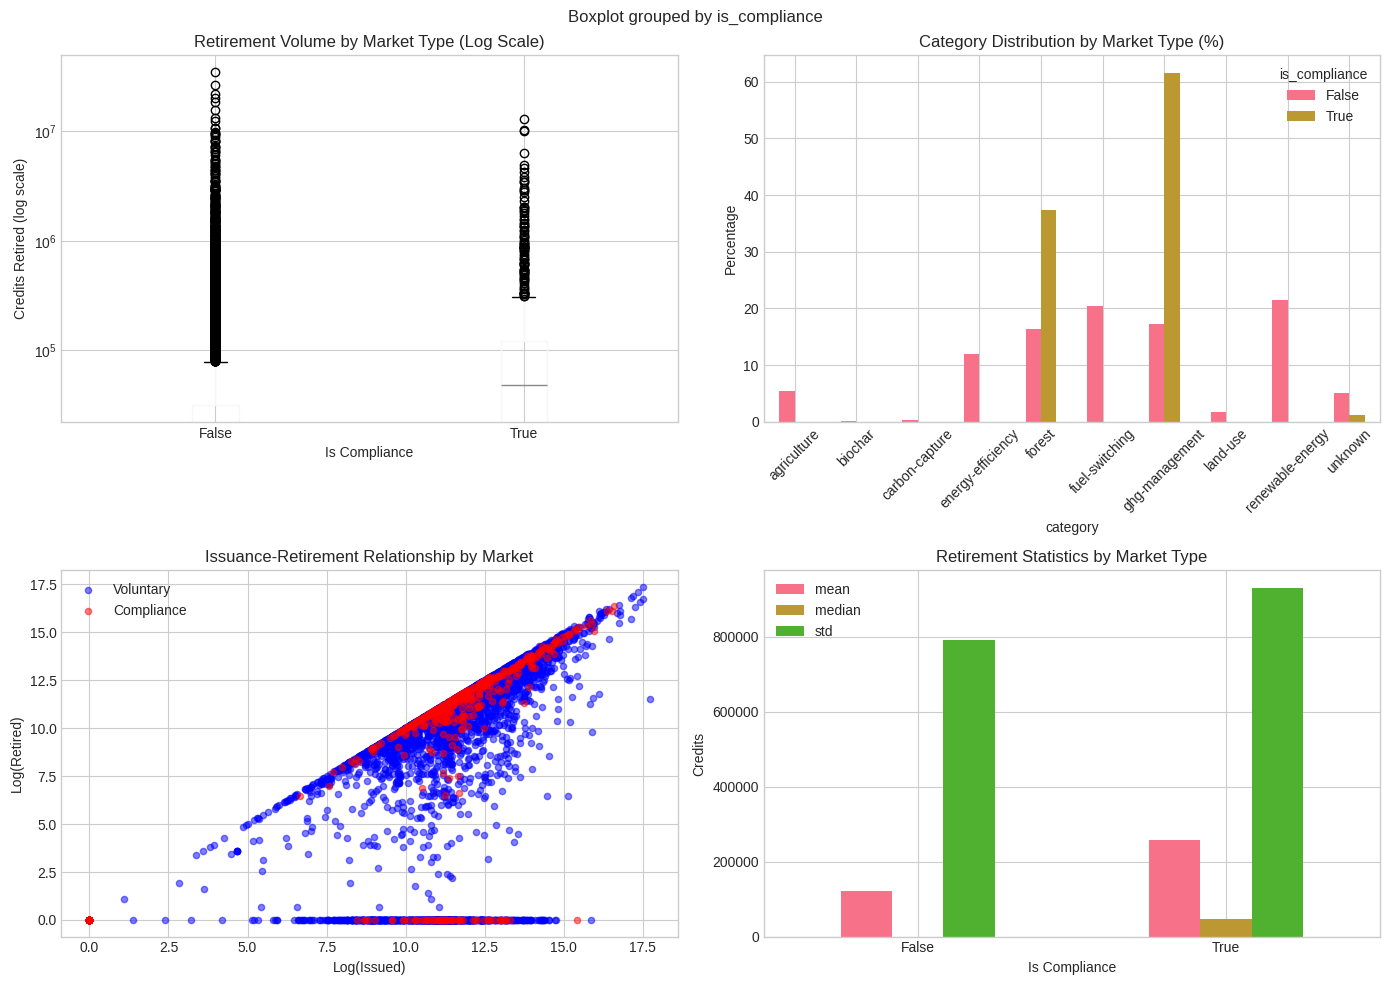

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Retirement distribution by market type
df_regression.boxplot(column='retired', by='is_compliance', ax=axes[0,0])
axes[0,0].set_yscale('log')
axes[0,0].set_title('Retirement Volume by Market Type (Log Scale)')
axes[0,0].set_xlabel('Is Compliance')
axes[0,0].set_ylabel('Credits Retired (log scale)')

# Plot 2: Category distribution by market
market_category_dist = pd.crosstab(df_regression['category'],
                                  df_regression['is_compliance'],
                                  normalize='columns') * 100
market_category_dist.plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Category Distribution by Market Type (%)')
axes[0,1].set_ylabel('Percentage')
axes[0,1].tick_params(axis='x', rotation=45)

# Plot 3: Issuance-Retirement relationship by market
for market, color, label in [(False, 'blue', 'Voluntary'), (True, 'red', 'Compliance')]:
    subset = df_regression[df_regression['is_compliance'] == market]
    axes[1,0].scatter(subset['log_issued'], subset['log_retired'],
                     alpha=0.5, color=color, label=label, s=20)
axes[1,0].set_xlabel('Log(Issued)')
axes[1,0].set_ylabel('Log(Retired)')
axes[1,0].set_title('Issuance-Retirement Relationship by Market')
axes[1,0].legend()

# Plot 4: Summary statistics
summary_stats = df_regression.groupby('is_compliance')['retired'].agg(['mean', 'median', 'std'])
summary_stats.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Retirement Statistics by Market Type')
axes[1,1].set_xlabel('Is Compliance')
axes[1,1].set_ylabel('Credits')
axes[1,1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

2.3.7 Key Findings

In [32]:
print("\n" + "=" * 80)
print("EMPIRICAL ANALYSIS SUMMARY")
print("=" * 80)
print("""
Key Findings:
1. Market Structure: Voluntary and compliance markets show distinct project compositions
2. Perfect Separation: Several categories exist only in voluntary markets
3. Statistical Approach: Separate models by market type avoid multicollinearity
4. Robustness: Non-parametric tests confirm parametric findings
""")


EMPIRICAL ANALYSIS SUMMARY

Key Findings:
1. Market Structure: Voluntary and compliance markets show distinct project compositions
2. Perfect Separation: Several categories exist only in voluntary markets
3. Statistical Approach: Separate models by market type avoid multicollinearity
4. Robustness: Non-parametric tests confirm parametric findings



# 3.PROJECT-CREDIT INTEGRATION: TIMING ANALYSIS

*   Research Question: How do project-level variables relate to timing of issuances and retirements?

## 3.1 Data Integration and Temporal Variable Creation

In [33]:
# Merge project and credit transaction data
df_timing = pd.merge(
    df_projects_processed,
    credits,
    on='project_id',
    how='inner'
)

# Convert date columns to datetime and remove timezone info
df_timing['transaction_date'] = pd.to_datetime(df_timing['transaction_date']).dt.tz_localize(None)

print("Temporal Analysis Dataset:")
print(f"Total transactions: {len(df_timing)}")
print(f"Unique projects: {df_timing['project_id'].nunique()}")
print(f"Date range: {df_timing['transaction_date'].min()} to {df_timing['transaction_date'].max()}")

Temporal Analysis Dataset:
Total transactions: 97415
Unique projects: 2035
Date range: 2009-02-20 00:00:00 to 2025-07-08 00:00:00


## 3.2 Calculate Key Timing Metrics

In [34]:
# Separate issuances and retirements
df_issuances = df_timing[df_timing['transaction_type'] == 'issuance'].copy()
df_retirements = df_timing[df_timing['transaction_type'] == 'retirement'].copy()

# Calculate project-level timing metrics
project_timing_metrics = []

for project_id in df_timing['project_id'].unique():
    project_data = df_timing[df_timing['project_id'] == project_id]
    project_info = project_data.iloc[0]  # Get project characteristics

    # Get transaction dates
    issuance_dates = project_data[project_data['transaction_type'] == 'issuance']['transaction_date']
    retirement_dates = project_data[project_data['transaction_type'] == 'retirement']['transaction_date']

    # Calculate metrics
    metrics = {
        'project_id': project_id,
        'category': project_info['category'],
        'country': project_info['country'],
        'registry': project_info['registry'],
        'protocol': project_info['protocol'],
        'is_compliance': project_info['is_compliance'],
        'status': project_info['status']
    }

    # Timing metrics
    if len(issuance_dates) > 0:
        metrics['first_issuance'] = issuance_dates.min()
        metrics['last_issuance'] = issuance_dates.max()
        metrics['n_issuances'] = len(issuance_dates)
        metrics['issuance_span_days'] = (issuance_dates.max() - issuance_dates.min()).days
        metrics['issuance_year'] = issuance_dates.min().year

    if len(retirement_dates) > 0:
        metrics['first_retirement'] = retirement_dates.min()
        metrics['last_retirement'] = retirement_dates.max()
        metrics['n_retirements'] = len(retirement_dates)
        metrics['retirement_span_days'] = (retirement_dates.max() - retirement_dates.min()).days

    # Time between first issuance and first retirement
    if len(issuance_dates) > 0 and len(retirement_dates) > 0:
        metrics['days_to_first_retirement'] = (retirement_dates.min() - issuance_dates.min()).days
        metrics['active_period_days'] = (retirement_dates.max() - issuance_dates.min()).days

    project_timing_metrics.append(metrics)

# Convert to DataFrame
df_project_timing = pd.DataFrame(project_timing_metrics)

print(f"\nProject timing metrics calculated for {len(df_project_timing)} projects")


Project timing metrics calculated for 2035 projects


## 3.3 Analyze Timing Patterns by Project Characteristics

In [35]:
# Category-based timing analysis
category_timing = df_project_timing.groupby('category').agg({
    'days_to_first_retirement': ['mean', 'median', 'std', 'count'],
    'active_period_days': ['mean', 'median'],
    'n_issuances': 'mean',
    'n_retirements': 'mean'
}).round(2)

# Flatten column names
category_timing.columns = ['_'.join(col).strip() for col in category_timing.columns]
category_timing = category_timing.sort_values('days_to_first_retirement_median')

print("\n" + "=" * 80)
print("TIMING PATTERNS BY PROJECT CATEGORY")
print("=" * 80)
print(category_timing)

# Registry-based timing analysis
registry_timing = df_project_timing.groupby('registry').agg({
    'days_to_first_retirement': ['mean', 'median', 'count'],
    'active_period_days': ['mean', 'median']
}).round(2)

registry_timing.columns = ['_'.join(col).strip() for col in registry_timing.columns]

print("\n" + "=" * 80)
print("TIMING PATTERNS BY REGISTRY")
print("=" * 80)
print(registry_timing)


TIMING PATTERNS BY PROJECT CATEGORY
                   days_to_first_retirement_mean  \
category                                           
agriculture                                76.00   
carbon-capture                             42.33   
land-use                                  553.44   
energy-efficiency                         823.14   
fuel-switching                           1177.32   
ghg-management                           1116.88   
forest                                   1130.77   
renewable-energy                         2104.29   
biochar                                      NaN   

                   days_to_first_retirement_median  \
category                                             
agriculture                                    0.0   
carbon-capture                                 4.0   
land-use                                     189.0   
energy-efficiency                            306.0   
fuel-switching                               308.0   
ghg-manageme

## 3.4 Vintage Analysis - Credit Age at Retirement

In [36]:
# Calculate vintage age for each retirement
# Handle timezone issues
df_retirements['vintage_date'] = pd.to_datetime(df_retirements['vintage']).dt.tz_localize(None)
df_retirements['transaction_date'] = pd.to_datetime(df_retirements['transaction_date']).dt.tz_localize(None)

df_retirements['vintage_age_days'] = (
    df_retirements['transaction_date'] - df_retirements['vintage_date']
).dt.days
df_retirements['vintage_age_years'] = df_retirements['vintage_age_days'] / 365.25

# Analyze vintage age by project characteristics
vintage_analysis = df_retirements.groupby(['category', 'is_compliance']).agg({
    'vintage_age_years': ['mean', 'median', 'std', 'count']
}).round(2)

print("\n" + "=" * 80)
print("CREDIT AGE AT RETIREMENT (VINTAGE ANALYSIS)")
print("=" * 80)
print(vintage_analysis)



CREDIT AGE AT RETIREMENT (VINTAGE ANALYSIS)
                                vintage_age_years                    
                                             mean median   std  count
category          is_compliance                                      
agriculture       False                     54.10  54.02  0.81     99
carbon-capture    False                     54.58  54.64  0.68    187
energy-efficiency False                     54.21  54.40  0.93    610
forest            False                     54.48  54.63  0.89  29796
fuel-switching    False                     54.00  54.10  0.97   1937
ghg-management    False                     54.47  54.69  0.83   2860
land-use          False                     54.23  54.41  0.88   1730
renewable-energy  False                     54.11  54.21  0.92  49247


## 3.5 Temporal Evolution - How Timing Patterns Change Over Time

In [37]:
# Group projects by first issuance year
temporal_evolution = df_project_timing.groupby('issuance_year').agg({
    'days_to_first_retirement': ['mean', 'median', 'count'],
    'active_period_days': 'mean'
}).round(2)

temporal_evolution.columns = ['_'.join(col).strip() for col in temporal_evolution.columns]

print("\n" + "=" * 80)
print("TEMPORAL EVOLUTION OF TIMING PATTERNS")
print("=" * 80)
print(temporal_evolution.tail(10))  # Show last 10 years



TEMPORAL EVOLUTION OF TIMING PATTERNS
               days_to_first_retirement_mean  days_to_first_retirement_median  \
issuance_year                                                                   
2016                                 2389.24                           2330.0   
2017                                 1973.87                           1833.0   
2018                                 1604.39                           1538.5   
2019                                 1208.70                           1169.0   
2020                                  873.64                            784.5   
2021                                  483.45                            387.0   
2022                                  237.91                            148.0   
2023                                  193.18                            135.0   
2024                                  107.27                             52.0   
2025                                   33.47                          

## 3.6 Statistical Analysis of Timing Determinants

In [38]:

# Regression analysis for days to first retirement
# Prepare data for regression
df_timing_regression = df_project_timing.dropna(subset=['days_to_first_retirement']).copy()

# Log transform the dependent variable (handling zeros)
df_timing_regression['log_days_to_retirement'] = np.log1p(df_timing_regression['days_to_first_retirement'])

# Create dummy variables for top categories
top_categories = df_timing_regression['category'].value_counts().head(5).index
df_timing_regression['category_grouped'] = df_timing_regression['category'].apply(
    lambda x: x if x in top_categories else 'Other'
)

print("\n" + "=" * 80)
print("REGRESSION ANALYSIS: DETERMINANTS OF TIME TO RETIREMENT")
print("=" * 80)

# Regression model
formula_timing = '''log_days_to_retirement ~ C(category_grouped) + C(registry) +
                   C(is_compliance) + n_issuances + issuance_year'''

try:
    timing_model = smf.ols(formula_timing, data=df_timing_regression).fit(cov_type='HC3')

    print(f"Model Statistics:")
    print(f"N = {int(timing_model.nobs)}")
    print(f"R-squared = {timing_model.rsquared:.4f}")
    print(f"Adj. R-squared = {timing_model.rsquared_adj:.4f}")

    # Show significant predictors
    print("\nSignificant predictors of time to retirement (p < 0.05):")
    sig_vars = timing_model.pvalues[timing_model.pvalues < 0.05]
    for var in sig_vars.index:
        if var != 'Intercept':
            coef = timing_model.params[var]
            print(f"{var}: {coef:.4f} (p={sig_vars[var]:.4f})")

except Exception as e:
    print(f"Regression failed: {e}")


REGRESSION ANALYSIS: DETERMINANTS OF TIME TO RETIREMENT
Model Statistics:
N = 892
R-squared = 0.5638
Adj. R-squared = 0.5603

Significant predictors of time to retirement (p < 0.05):
C(category_grouped)[T.energy-efficiency]: 2.0905 (p=0.0000)
C(category_grouped)[T.forest]: 1.5638 (p=0.0003)
C(category_grouped)[T.fuel-switching]: 1.6572 (p=0.0001)
C(category_grouped)[T.ghg-management]: 1.3583 (p=0.0024)
C(category_grouped)[T.renewable-energy]: 1.7884 (p=0.0000)
C(is_compliance)[T.True]: -0.0000 (p=0.0407)
n_issuances: 0.0278 (p=0.0033)
issuance_year: -0.3516 (p=0.0000)


## 3.7 Comprehensive Visualization

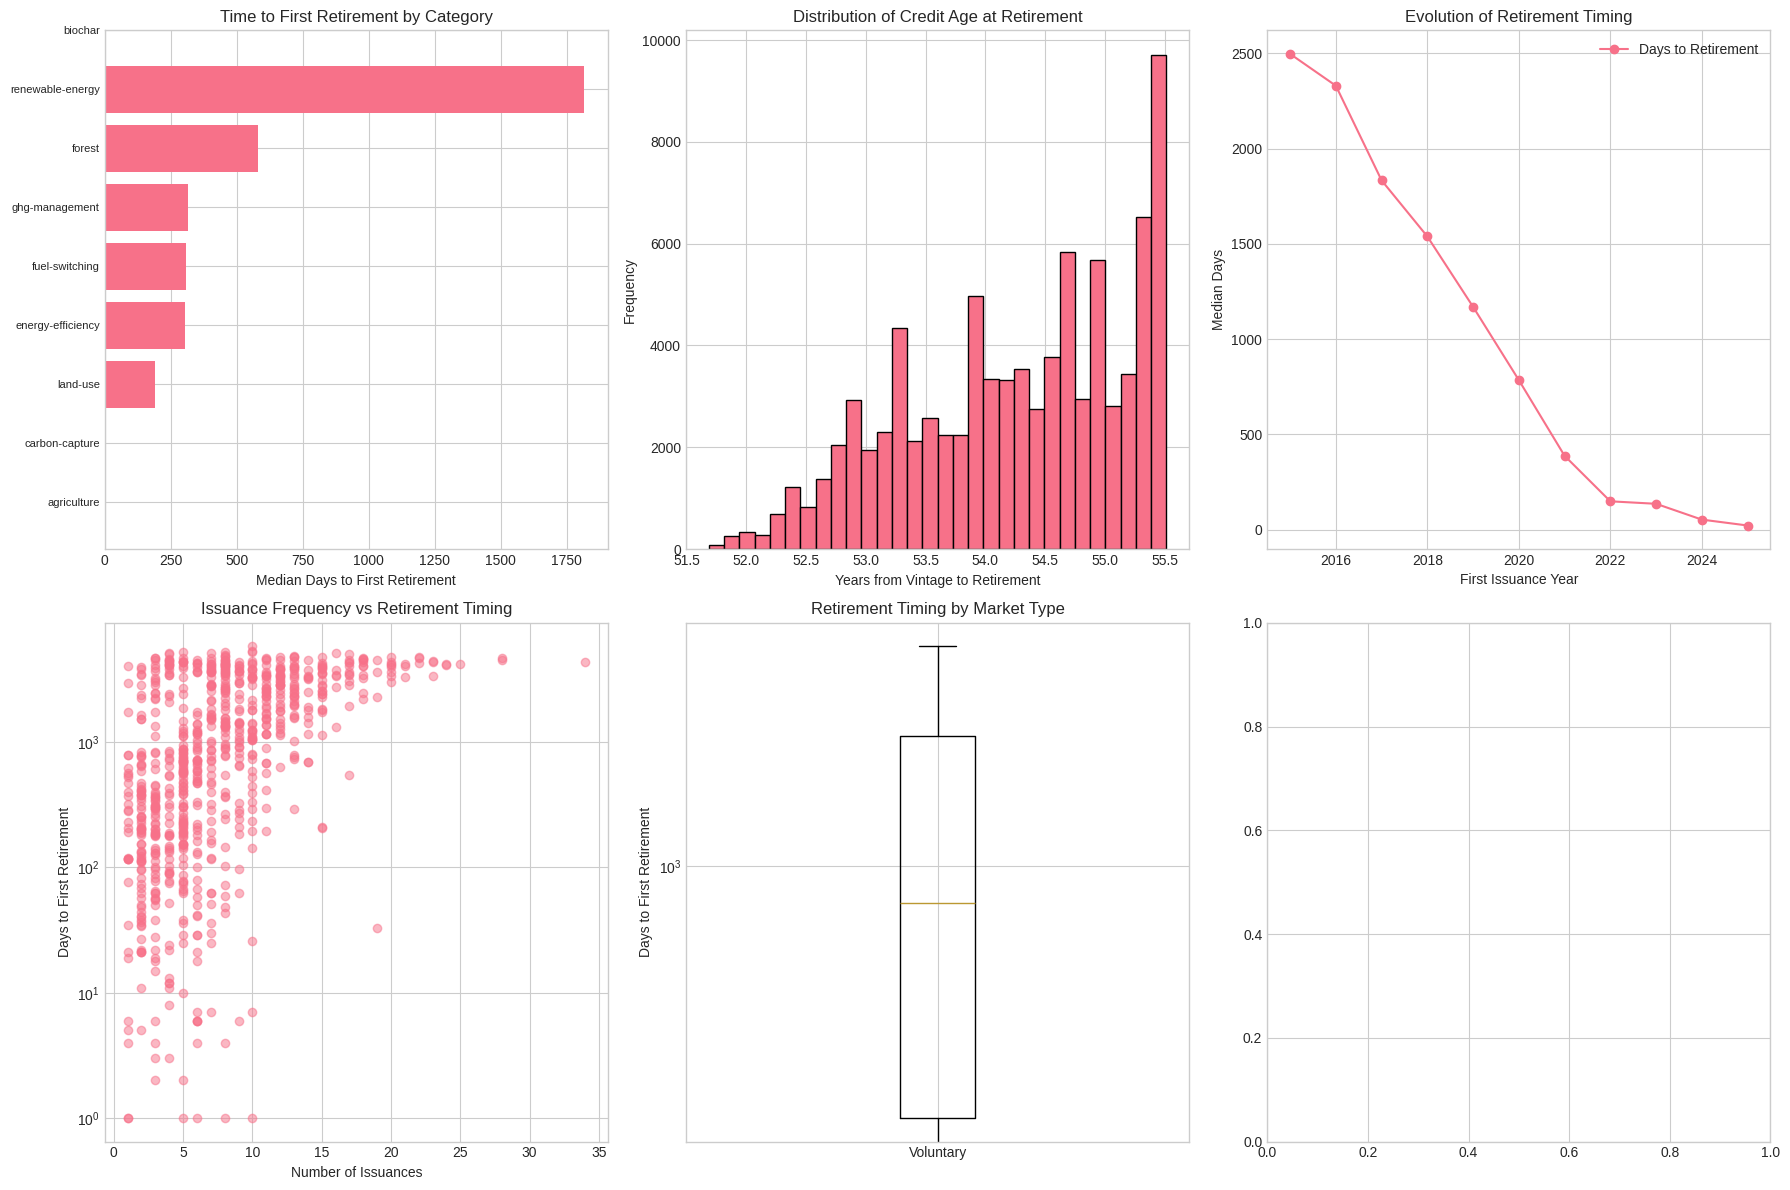

In [40]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Days to retirement by category
category_timing_plot = category_timing.sort_values('days_to_first_retirement_median')
axes[0,0].barh(range(len(category_timing_plot)),
               category_timing_plot['days_to_first_retirement_median'])
axes[0,0].set_yticks(range(len(category_timing_plot)))
axes[0,0].set_yticklabels(category_timing_plot.index, fontsize=8)
axes[0,0].set_xlabel('Median Days to First Retirement')
axes[0,0].set_title('Time to First Retirement by Category')

# Plot 2: Vintage age distribution
vintage_ages = df_retirements['vintage_age_years'].dropna()
if len(vintage_ages) > 0:
    axes[0,1].hist(vintage_ages, bins=30, edgecolor='black')
    axes[0,1].set_xlabel('Years from Vintage to Retirement')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('Distribution of Credit Age at Retirement')

# Plot 3: Temporal evolution
temporal_data = temporal_evolution.reset_index()
if 'issuance_year' in temporal_data.columns:
    temporal_data = temporal_data[temporal_data['issuance_year'] >= 2015]  # Recent years
    if len(temporal_data) > 0:
        axes[0,2].plot(temporal_data['issuance_year'],
                       temporal_data['days_to_first_retirement_median'],
                       marker='o', label='Days to Retirement')
        axes[0,2].set_xlabel('First Issuance Year')
        axes[0,2].set_ylabel('Median Days')
        axes[0,2].set_title('Evolution of Retirement Timing')
        axes[0,2].legend()

# Plot 4: Issuance frequency vs retirement timing
valid_data = df_project_timing.dropna(subset=['n_issuances', 'days_to_first_retirement'])
if len(valid_data) > 0:
    axes[1,0].scatter(valid_data['n_issuances'],
                      valid_data['days_to_first_retirement'],
                      alpha=0.5)
    axes[1,0].set_xlabel('Number of Issuances')
    axes[1,0].set_ylabel('Days to First Retirement')
    axes[1,0].set_title('Issuance Frequency vs Retirement Timing')
    axes[1,0].set_yscale('log')

# Plot 5: Compliance vs Voluntary timing
timing_by_compliance = df_project_timing.groupby('is_compliance')['days_to_first_retirement'].apply(
    lambda x: x.dropna().tolist()
)
if len(timing_by_compliance) > 0:
    box_data = []
    labels = []
    for compliance_status, times in timing_by_compliance.items():
        if len(times) > 0:
            box_data.append(times)
            labels.append('Compliance' if compliance_status else 'Voluntary')

    if len(box_data) > 0:
        axes[1,1].boxplot(box_data, labels=labels)
        axes[1,1].set_ylabel('Days to First Retirement')
        axes[1,1].set_title('Retirement Timing by Market Type')
        axes[1,1].set_yscale('log')

plt.tight_layout()
plt.show()

## 3.9 Key Findings Summary

In [41]:
print("\n" + "=" * 80)
print("KEY TIMING INSIGHTS")
print("=" * 80)

# Calculate summary statistics
days_to_retire = df_project_timing['days_to_first_retirement'].dropna()
if len(days_to_retire) > 0:
    median_time_to_retirement = days_to_retire.median()
    print(f"1. Median time from first issuance to first retirement: {median_time_to_retirement:.0f} days")

vintage_ages = df_retirements['vintage_age_years'].dropna()
if len(vintage_ages) > 0:
    mean_vintage_age = vintage_ages.mean()
    print(f"2. Average credit age at retirement: {mean_vintage_age:.1f} years")

print(f"3. Fastest retiring category: {category_timing.index[0]}")
print(f"4. Most active registry (by timing): {registry_timing['days_to_first_retirement_median'].idxmin()}")

# Statistical tests
from scipy import stats

# Test difference between compliance and voluntary
voluntary_times = df_project_timing[df_project_timing['is_compliance']==False]['days_to_first_retirement'].dropna()
compliance_times = df_project_timing[df_project_timing['is_compliance']==True]


KEY TIMING INSIGHTS
1. Median time from first issuance to first retirement: 746 days
2. Average credit age at retirement: 54.3 years
3. Fastest retiring category: agriculture
4. Most active registry (by timing): verra


# 4. News Reflection

In [56]:
# Check Transaction Date on years
df_timing['year'] = df_timing['transaction_date'].dt.year
print("\nYearly Transaction Count:")
print(df_timing['year'].value_counts().sort_index())


Yearly Transaction Count:
year
2009.0      182
2010.0      297
2011.0      385
2012.0      489
2013.0      573
2014.0      341
2015.0      395
2016.0      261
2017.0      309
2018.0      289
2019.0      523
2020.0      807
2021.0     1907
2022.0    11637
2023.0    23763
2024.0    32220
2025.0    23036
Name: count, dtype: int64


## 4.1 Paris Agreement

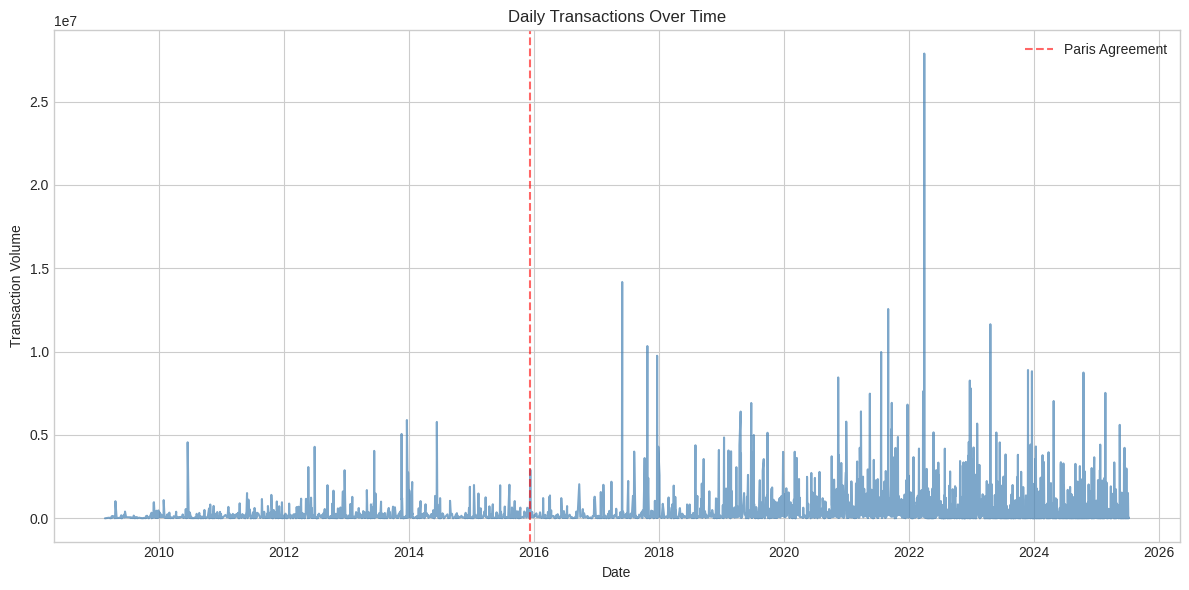

In [57]:
# Summarize the daily transaction volume by date.
daily_transactions = df_timing.groupby('transaction_date')['quantity'].sum().reset_index()

# Visualize the daily trading volume time series
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(daily_transactions['transaction_date'], daily_transactions['quantity'], alpha=0.7, color='steelblue')
plt.title('Daily Transactions Over Time')
plt.xlabel('Date')
plt.ylabel('Transaction Volume')
plt.axvline(pd.Timestamp('2015-12-12'), color='red', linestyle='--', alpha=0.6, label='Paris Agreement')
plt.legend()
plt.tight_layout()
plt.show()

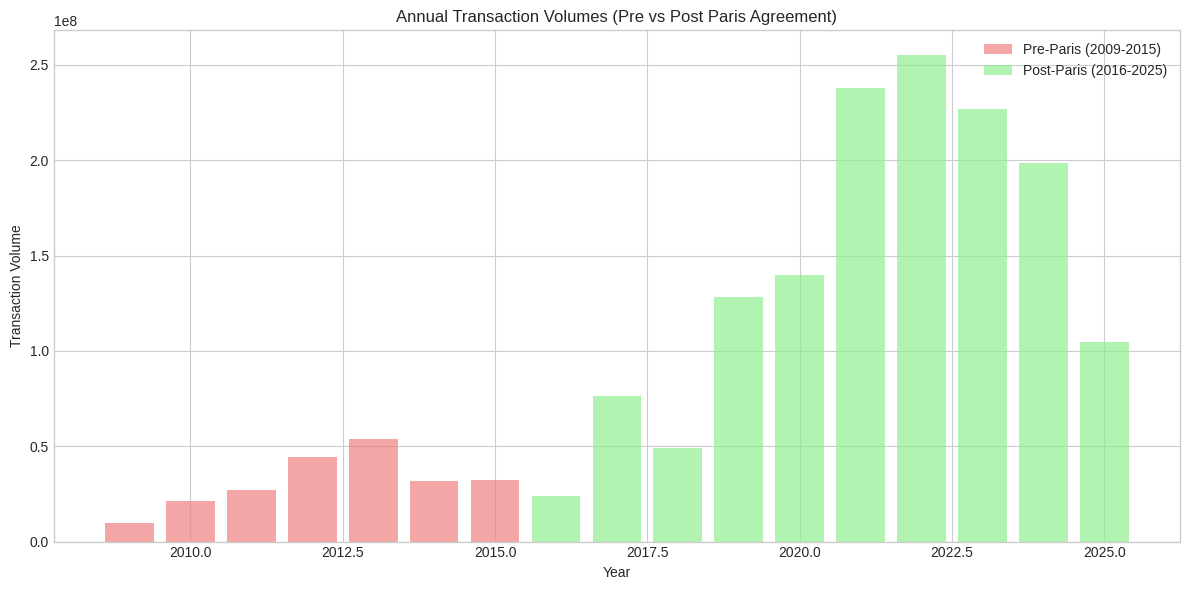

In [58]:
annual_transactions = df_timing.groupby('year')['quantity'].sum().reset_index()

# Separate data before and after the Paris Agreement
pre_paris = annual_transactions[annual_transactions['year'] < 2016]
post_paris = annual_transactions[annual_transactions['year'] >= 2016]

plt.figure(figsize=(12, 6))
plt.bar(pre_paris['year'], pre_paris['quantity'], width=0.8, label='Pre-Paris (2009-2015)', color='lightcoral', alpha=0.7)
plt.bar(post_paris['year'], post_paris['quantity'], width=0.8, label='Post-Paris (2016-2025)', color='lightgreen', alpha=0.7)
plt.title('Annual Transaction Volumes (Pre vs Post Paris Agreement)')
plt.xlabel('Year')
plt.ylabel('Transaction Volume')
plt.legend()
plt.tight_layout()
plt.show()

In [77]:
# 1. T-test
t_stat, t_pvalue = stats.ttest_ind(pre_paris, post_paris)
print(f"T-test: t-statistic = {t_stat:.4f}, p-value = {t_pvalue:.4f}")

# 2. Mann-Whitney U test
u_stat, u_pvalue = stats.mannwhitneyu(pre_paris, post_paris, alternative='two-sided')
print(f"Mann-Whitney U test: U-statistic = {u_stat:.4f}, p-value = {u_pvalue:.4f}")

# 3. Statistics
print(f"\nPre-Paris (2009-2015):")
print(f"  Mean: {pre_paris.mean():.2f}")
print(f"  Std: {pre_paris.std():.2f}")
print(f"  Median: {pre_paris.median():.2f}")

print(f"\nPost-Paris (2016-2025):")
print(f"  Mean: {post_paris.mean():.2f}")
print(f"  Std: {post_paris.std():.2f}")
print(f"  Median: {post_paris.median():.2f}")

T-test: t-statistic = -3.5513, p-value = 0.0029
Mann-Whitney U test: U-statistic = 6.0000, p-value = 0.0031

Pre-Paris (2009-2015):
  Mean: 31472449.57
  Std: 14581358.97
  Median: 32006809.00

Post-Paris (2016-2025):
  Mean: 144086946.80
  Std: 82215807.74
  Median: 134061083.50


## 4.2 Anomaly Dates

In [68]:
# Calculate the rolling mean and standard deviation
window_size = 15
daily_transactions['rolling_mean'] = daily_transactions['quantity'].rolling(window=window_size, center=True).mean()
daily_transactions['rolling_std'] = daily_transactions['quantity'].rolling(window=window_size, center=True).std()

# Identify outliers based on z-score
daily_transactions['z_score'] = (daily_transactions['quantity'] - daily_transactions['rolling_mean']) / daily_transactions['rolling_std']
daily_transactions['is_anomaly'] = abs(daily_transactions['z_score']) > 3  # 定义 z-score 阈值

# Output abnormal value date
anomalies = daily_transactions[daily_transactions['is_anomaly']]
print("\nTop Anomaly Dates:")
print(anomalies[['transaction_date', 'quantity', 'z_score']].sort_values('quantity', ascending=False).head(10))


Top Anomaly Dates:
     transaction_date  quantity   z_score
2058       2022-03-31  27880957  3.475307
1115       2017-05-31  14177917  3.612266
1882       2021-09-01  12558246  3.551496
2382       2023-04-21  11643955  3.508727
1175       2017-10-25  10334692  3.520307
1855       2021-07-22   9976753  3.562840
1200       2017-12-21   9753697  3.219568
2583       2023-11-27   8898827  3.525844
2604       2023-12-20   8823522  3.400146
2884       2024-10-16   8745405  3.336273


In [78]:
print("\n=== Anomaly Analysis Note ===")
print("Top 10 anomaly dates have been identified with significantly high transaction volumes.")
print("These anomalies may be related to:")
print("- Major policy announcements (e.g., environmental regulations)")
print("- Geopolitical events (e.g., 2022 Russia-Ukraine conflict)")
print("- Quarter/year-end adjustments")
print("- Supply chain disruptions")
print("Further investigation would be needed to establish causal relationships.\n")


=== Anomaly Analysis Note ===
Top 10 anomaly dates have been identified with significantly high transaction volumes.
These anomalies may be related to:
- Major policy announcements (e.g., environmental regulations)
- Geopolitical events (e.g., 2022 Russia-Ukraine conflict)
- Quarter/year-end adjustments
- Supply chain disruptions
Further investigation would be needed to establish causal relationships.



## 4.3 Other News

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# Read your actual data
credits = pd.read_csv('credits.csv')
projects = pd.read_csv('projects.csv')

# Filter for retirement transactions only
retirements = credits[credits['transaction_type'] == 'retirement'].copy()

# Create daily retirement aggregation
daily_retired = retirements.groupby('transaction_date')['quantity'].sum().reset_index()
daily_retired.columns = ['transaction_date', 'retired']
daily_retired['transaction_date'] = pd.to_datetime(daily_retired['transaction_date'])

print(f"Data range: {daily_retired['transaction_date'].min()} to {daily_retired['transaction_date'].max()}")
print(f"Total retirement transactions: {len(retirements):,}")
print(f"Total retired volume: {retirements['quantity'].sum():,}")

Data range: 2004-12-31 00:00:00+00:00 to 2025-07-08 00:00:00+00:00
Total retirement transactions: 440,266
Total retired volume: 1,374,272,010


Data range: 2004-12-31 00:00:00 to 2025-07-08 00:00:00
Total retirement transactions: 440,266
Total retired volume: 1,374,272,010

Events within data range: 6

Events included:
  2021-05-26: Dutch court orders Shell to cut emissions...
  2021-11-03: COP26 Article 6 carbon market rules agreed...
  2022-05-15: Guardian: Verra rainforest credits worthless...
  2023-01-18: Guardian: Forest carbon offsets flawed...
  2023-08-24: Chevron abandons carbon offset plans...
  2023-12-10: COP28 finalizes carbon market framework...

=== Event Impact Analysis (30-day window) ===

Event: Dutch court orders Shell to cut emissions...
Date: 2021-05-26
Pre-event daily average: 459,106
Post-event daily average: 268,488
Change: -41.5%
Statistically significant: No (p=0.321)

Event: COP26 Article 6 carbon market rules agreed...
Date: 2021-11-03
Pre-event daily average: 2,750,988
Post-event daily average: 413,233
Change: -85.0%
Statistically significant: No (p=0.264)

Event: Guardian: Verra rainforest credit

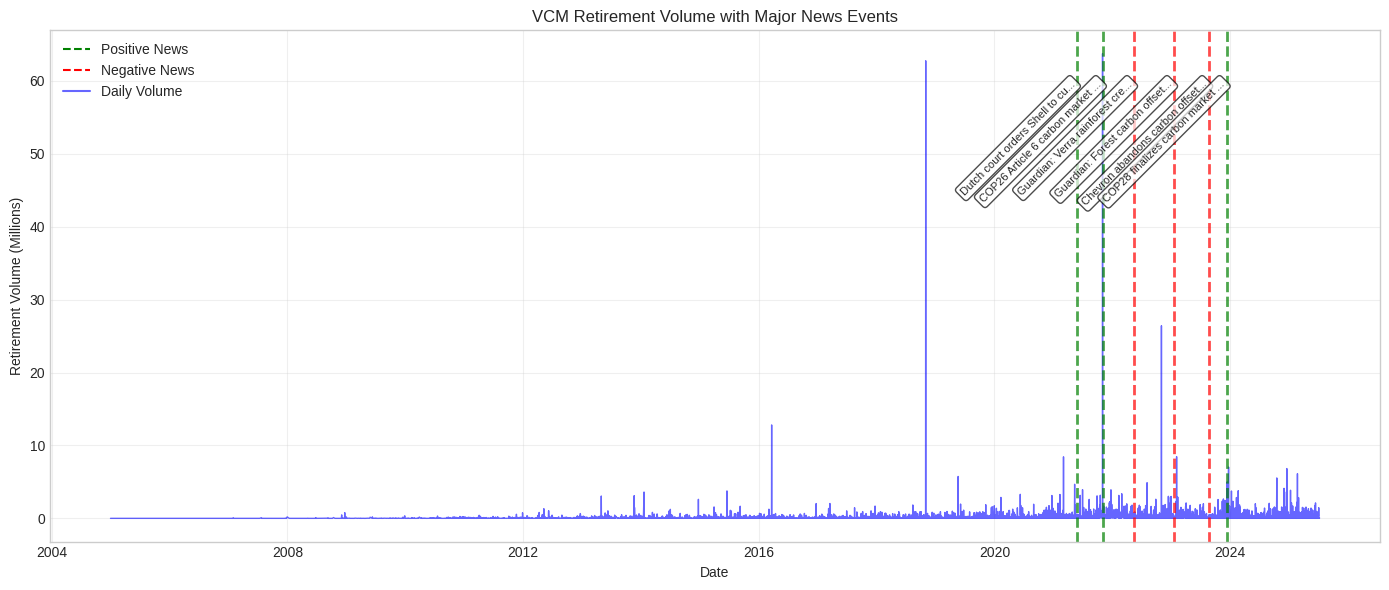


=== Summary by Event Type ===
                 mean  count
type                        
corporate    5.272494      1
legal      -41.519400      1
regulatory   8.709441      2
scandal     -8.756814      2

=== Summary by Sentiment ===
               mean  count
sentiment                 
negative  -4.080378      3
positive  -8.033506      3


In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# Read your actual data
credits = pd.read_csv('credits.csv')
projects = pd.read_csv('projects.csv')

# Filter for retirement transactions only
retirements = credits[credits['transaction_type'] == 'retirement'].copy()

# Create daily retirement aggregation
daily_retired = retirements.groupby('transaction_date')['quantity'].sum().reset_index()
daily_retired.columns = ['transaction_date', 'retired']

# Convert to datetime and handle timezone
daily_retired['transaction_date'] = pd.to_datetime(daily_retired['transaction_date'])
# Remove timezone info for easier comparison
daily_retired['transaction_date'] = daily_retired['transaction_date'].dt.tz_localize(None)

print(f"Data range: {daily_retired['transaction_date'].min()} to {daily_retired['transaction_date'].max()}")
print(f"Total retirement transactions: {len(retirements):,}")
print(f"Total retired volume: {retirements['quantity'].sum():,}")

# Define major VCM news events
major_events = pd.DataFrame({
    'date': [
        '2021-05-26',  # Shell court ruling
        '2021-11-03',  # COP26 Article 6
        '2022-05-15',  # Guardian Verra investigation
        '2023-01-18',  # Guardian follow-up
        '2023-08-24',  # Chevron abandons offsets
        '2023-12-10',  # COP28 carbon markets
    ],
    'event': [
        'Dutch court orders Shell to cut emissions',
        'COP26 Article 6 carbon market rules agreed',
        'Guardian: Verra rainforest credits worthless',
        'Guardian: Forest carbon offsets flawed',
        'Chevron abandons carbon offset plans',
        'COP28 finalizes carbon market framework'
    ],
    'type': ['legal', 'regulatory', 'scandal', 'scandal', 'corporate', 'regulatory'],
    'sentiment': ['positive', 'positive', 'negative', 'negative', 'negative', 'positive']
})

# Convert to datetime without timezone
major_events['date'] = pd.to_datetime(major_events['date'])

# Filter events within your data range
major_events = major_events[
    (major_events['date'] >= daily_retired['transaction_date'].min()) &
    (major_events['date'] <= daily_retired['transaction_date'].max())
]

print(f"\nEvents within data range: {len(major_events)}")
print("\nEvents included:")
for _, event in major_events.iterrows():
    print(f"  {event['date'].strftime('%Y-%m-%d')}: {event['event'][:50]}...")

# Event window analysis function
def analyze_event_window(event_date, event_name, window_days=30):
    """
    Analyze retirement patterns around a news event
    """
    # Define pre and post windows
    pre_start = event_date - pd.Timedelta(days=window_days)
    pre_end = event_date - pd.Timedelta(days=1)
    post_start = event_date
    post_end = event_date + pd.Timedelta(days=window_days)

    # Get data for windows
    pre_data = daily_retired[
        (daily_retired['transaction_date'] >= pre_start) &
        (daily_retired['transaction_date'] <= pre_end)
    ]['retired']

    post_data = daily_retired[
        (daily_retired['transaction_date'] >= post_start) &
        (daily_retired['transaction_date'] <= post_end)
    ]['retired']

    # Calculate statistics
    if len(pre_data) > 0 and len(post_data) > 0:
        pre_mean = pre_data.mean()
        post_mean = post_data.mean()
        change_pct = ((post_mean - pre_mean) / pre_mean * 100) if pre_mean > 0 else 0

        # Statistical test
        t_stat, p_value = stats.ttest_ind(post_data, pre_data)

        return {
            'event': event_name,
            'date': event_date,
            'pre_mean': pre_mean,
            'post_mean': post_mean,
            'change_pct': change_pct,
            't_stat': t_stat,
            'p_value': p_value,
            'significant': p_value < 0.05
        }
    else:
        return None

# Analyze all events
results = []
for _, event in major_events.iterrows():
    result = analyze_event_window(event['date'], event['event'])
    if result:
        result['type'] = event['type']
        result['sentiment'] = event['sentiment']
        results.append(result)

if results:
    results_df = pd.DataFrame(results)

    # Display results
    print("\n=== Event Impact Analysis (30-day window) ===")
    for _, row in results_df.iterrows():
        print(f"\nEvent: {row['event'][:50]}...")
        print(f"Date: {row['date'].strftime('%Y-%m-%d')}")
        print(f"Pre-event daily average: {row['pre_mean']:,.0f}")
        print(f"Post-event daily average: {row['post_mean']:,.0f}")
        print(f"Change: {row['change_pct']:.1f}%")
        print(f"Statistically significant: {'Yes' if row['significant'] else 'No'} (p={row['p_value']:.3f})")

# Visualization
fig, ax = plt.subplots(figsize=(14, 6))

# Plot daily retirement volume
ax.plot(daily_retired['transaction_date'], daily_retired['retired']/1e6,
        alpha=0.6, color='blue', linewidth=1, label='Daily Retirement Volume')

# Mark events
for _, event in major_events.iterrows():
    color = 'green' if event['sentiment'] == 'positive' else 'red'
    ax.axvline(event['date'], color=color, linestyle='--', alpha=0.7, linewidth=2)

    # Add event label
    ax.text(event['date'], ax.get_ylim()[1]*0.9,
            event['event'][:30] + '...',
            rotation=45, fontsize=8, ha='right', va='top',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

ax.set_xlabel('Date')
ax.set_ylabel('Retirement Volume (Millions)')
ax.set_title('VCM Retirement Volume with Major News Events')
ax.grid(True, alpha=0.3)

# Add legend for event types
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='green', linestyle='--', label='Positive News'),
    Line2D([0], [0], color='red', linestyle='--', label='Negative News'),
    Line2D([0], [0], color='blue', alpha=0.6, label='Daily Volume')
]
ax.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()

# Summary statistics by event type
if results:
    print("\n=== Summary by Event Type ===")
    summary = pd.DataFrame(results).groupby('type')['change_pct'].agg(['mean', 'count'])
    print(summary)

    print("\n=== Summary by Sentiment ===")
    sentiment_summary = pd.DataFrame(results).groupby('sentiment')['change_pct'].agg(['mean', 'count'])
    print(sentiment_summary)